In [12]:
import os
import sys

# Necessary to import functions from utils
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import numpy as np
from utils.hdf5 import get_data_from_dataset
from utils.ets import split_into_bins
from utils.community_detection import reorder_communities
from utils.correlation import r_coeff_2mats
from time import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
import bct
import networkx as nx
from scipy.stats import sem

## Define functions

Some functions are defined directly here; others are contained in separate modules (*utils.ets* or *utils.correlation* notably).

In [13]:
# Set verbosity according to the desired verbosity of the log function
time_counter = time()
verbosity = 2

def log(message, level=1, print_flag=True, track_time=True):
    """Log execution with time elapsed; similar to print() but with adjustable verbosity and time tracking.
    """
    
    global time_counter, verbosity

    elapsed_time = time() - time_counter
    time_counter = time()

    if print_flag and verbosity >= level:
        if track_time:
            print(f"Elapsed time: {elapsed_time:.2f} seconds.\n")
        print(message)

def flat_to_symmetric(flat, N):
    """Convert a flattened upper triangle vector to a full symmetric matrix."""
    mat = np.zeros((N, N))
    inds = np.triu_indices(N)
    mat[inds] = flat
    mat[(inds[1], inds[0])] = flat  # Reflect upper triangle to lower
    return mat

log("Example usage of the flat_to_symmetric and log functions:")

flat_upper_tri = np.array([1, 2, 3, 4, 5, 6])

log(f"Flattened upper triangle: {flat_upper_tri}")

log(f"Symmetric matrix:\n{flat_to_symmetric(flat_upper_tri, 3)}")

Elapsed time: 0.00 seconds.

Example usage of the flat_to_symmetric and log functions:
Elapsed time: 0.00 seconds.

Flattened upper triangle: [1 2 3 4 5 6]
Elapsed time: 0.00 seconds.

Symmetric matrix:
[[1. 2. 3.]
 [2. 4. 5.]
 [3. 5. 6.]]


## Neurovascular coupling

The neurovascular coupling is computed pixelwise, which means that we simply correlate (Pearson R) the time series of a GCaMP pixel with the time series of the corresponding (same location) HbT pixel.

Optionally, if *compute_lag* is set to True, the lag that yields the optimal correlation will be used within the temporal window specified by *max_shift*.

Make sure to remain consistent with the order used to compute the correlation, for instance always defining *signal1* as GCaMP and *signal2* as HbT, or vice versa. This will ensure that you have a consistent interpretation of what positive and negative lags mean (which signal comes before the other).

### 1. Define parameters

In [14]:
# These parameters are related to the lag. if compute_lag is True, the pixelwise lag between GCaMP and HbT timeseries
# yielding the maximum absolute Pearson R value will be computed

compute_lag = True # Whether or not to consider lag
max_shift_seconds = 6 # Max signal lag in seconds
fps = 3 # FPS of the data
max_shift = int(max_shift_seconds * fps) #  Max shift in indices

# These parameters are related to the data that is to be loaded

mouse_num = 396 # I personally work with mice numbers, but your file naming convention may vary. Change as appropriate.
signal1_str = "GCaMP" # The signal to use as the first signal; this is going to be used to load the correct dataset within thee HDF5 file
signal2_str = "HbT"   # Same goes for the second signal.
filename_str = "sample_dataset" # Additional file identifier; may also vary across datasets and users.

# Here I define the file naming convention I use; change this as appropriate
def signals_filename(mouse_num, filename_str):
    return f"sample_data/M{mouse_num}/M{mouse_num}_{filename_str}.h5"

# For instance, with mouse_num = 322 and filename_str = sample_dataset, the function will return the filepath
# "sample_data/M322/M322_sample_dataset.h5"

### 2. Load data

The data can be stored in various file formats such as *.tiff*, *.npy*, *.pkl* or *.h5* files. I personally prefer using HDF5 (*.h5*) files because it makes collecting and handling multiple datasets for the same mouse or experiment very easy, and it handles structuring and lazing loading very well. I use a GUI to create and process these datasets (that can be accessed with *launcher.py*), and all HDF5 file handling functions are contained in *utils.hdf5*.

In [15]:
# Alternate version of the data; larger and with different operations applied. Try it by un-commenting the line below
# filename_str = "sample_dataset_large"

signal1, attributes1 = get_data_from_dataset(signals_filename(mouse_num, filename_str), f"data/3d/{signal1_str}")
signal2, attributes2 = get_data_from_dataset(signals_filename(mouse_num, filename_str), f"data/3d/{signal2_str}")

In the example above, signals are loaded from the filepath defined by *signals_filename*, and contained in the dataset given by "data/3d/GCaMP" (or HbT). If you're unsure of the group and dataset structure of your file, you can easily explore it by opening it with the *launcher.py* GUI.

### 3. Compute lag and neurovascular coupling (correlations)

In [16]:
lag_mat, correlations_mat = r_coeff_2mats(signal1, signal2, max_shift=max_shift, lag=compute_lag, convert_to_s=True, fps=fps, squared=False)

The function *r_coeff_2mats* takes two 3d matrices (such as our GCaMP and HbT signals) and returns the 2d optimal lag matrix as well as the 2d correlation matrix. We can plot those two matrices to see what we are working with:

Important: as said above, make sure to remain consistent with the order of *signal1* and *signal2* to be able to interpret the lag map. The function returns negative lag when *signal1* is before *signal2*, and positive lag when *signal2* is before *signal1*. In the example below (*signal1* = GCaMP and *signal2* = HbT) the lag map is mostly blue (negative), which means that GCaMP usually slightly precedes HbT. Also make note of the *convert_to_s* argument, which allows switching between lag in frames and lag in seconds.

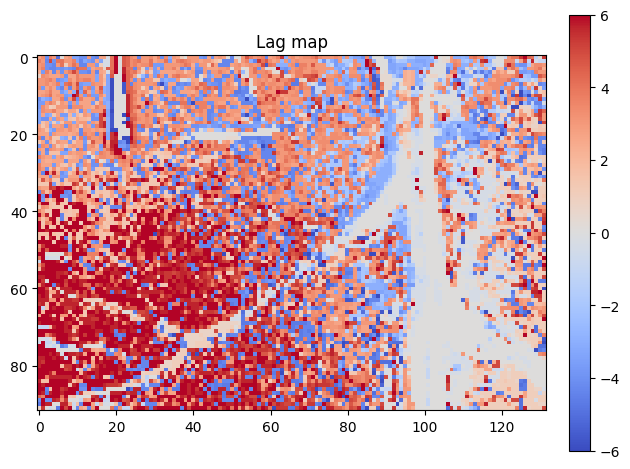

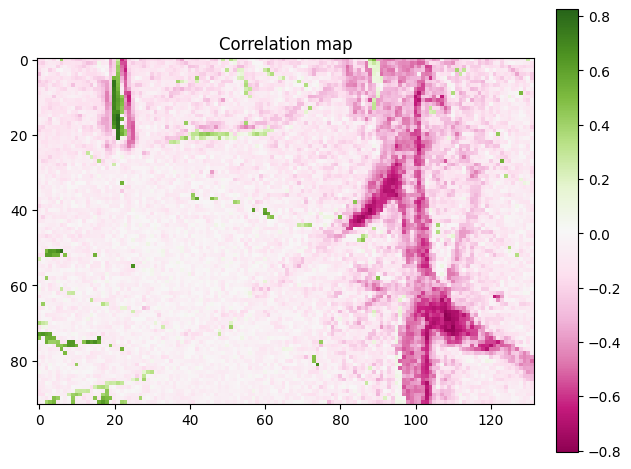

In [17]:
def show_matrix_with_colorbar(mat, cmap='viridis', title='Matrix Visualization'):
    fig, ax = plt.subplots()
    im = ax.imshow(mat, cmap=cmap)
    ax.set_title(title)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

show_matrix_with_colorbar(lag_mat, cmap="coolwarm", title="Lag map")
show_matrix_with_colorbar(correlations_mat, cmap="PiYG", title="Correlation map")

Do note that the sample dataset *sample_dataset.py* is taken from data from M396 and edited with the "HDF5 Processing" tab of the GUI. Specifically, it has been downsampled from 12 to 3 fps (*downsampling.py*), the ROI has been sized down (*ROI_selection.py*) and the time restricted to a total of 5 minutes (900 frames; *time_trimming.py*), before being repacked with "Repack HDF5" (otherwise the file size is not reduced automatically). The final file size is about 83 Mb. The original dataset, which was 8 minutes at 12 fps with the ROI being the whole field of view, had a total of about 3.28 Gb. By opening the sample dataset in the "HDF5 Processing" tab and selecting the datasets, you can see on the right the parameters with which the operations were run.

Procedures may be very long when file sizes are high and datasets are large. This is one of the reasons why HDF5 files come in handy, because unlike other file types such as *.pkl* and *.npy* files you can load only the parts that are of interest to you, which greatly limits the quantity of memory that is necessary. Make sure you're working with files that are as compact as possible (making use of "Repack HDF5" as needed). In some cases, like for the functional similarity case we're going to explore next, procedures quickly become extremely large and working with spatial bins of the original data becomes necessary.

For an example of a what a larger dataset (but not *that* large!) might look like, uncomment the second line (starting with *filename_str = ...*) in the data loading cell.

## Functional similarity

Where neurovascular coupling quantifies the pixelwise (or node-wise, region-wise, neuron-wise...) correlation between the neuronal and vascular signals, functional similarity quantifies the correlation between the neuronal and vascular *network structure*, via functional connectivity (FC).

### 1. Define parameters

In [26]:
del signal1, signal1_str, signal2, signal2_str, attributes1, attributes2, mouse_num, filename_str

# These parameters are related to the data that is to be loaded

mouse_num = 396 # I personally work with mice numbers, but your file naming convention may vary. Change as appropriate.
signal1_str = "GCaMP" # The signal to use as the first signal; this is going to be used to load the correct dataset within thee HDF5 file
signal2_str = "HbT"   # Same goes for the second signal.
filename_str = "sample_dataset_large" # Additional file identifier; may also vary across datasets and users.

# Here I define the file naming convention I use; change this as appropriate
def signals_filename(mouse_num, filename_str):
    return f"sample_data/M{mouse_num}/M{mouse_num}_{filename_str}.h5"

# For instance, with mouse_num = 322 and filename_str = sample_dataset, the function will return the filepath
# "sample_data/M322/M322_sample_dataset.h5"

# This parameter is related to spatial binning; more information on that below
bin_size = (10, 10)

Computing the FC matrix is very computationally costly because for a $N\times M\times T$ signal matrix (height x width x time), you obtain a $NM \times NM$ matrix, which can be very large. This is especially true if you are working with dFC matrices as you will end up with an even larger $NM \times NM \times T$ matrix (more on that later).

The way I usually do it is be pre-computing the dFC frames. dFC (dynamical functional connectivity) is the frame-wise computation of the FC matrix; there is a single dFC frame for every frame of signal, which informs you about the moment-to-moment fluctuations of network function. In short, it is the FC matrix you would obtain if your signal comprised only a single frame. The functional connectivity is then computed by taking the average over every frame.

I generally pre-compute the dFC and save it to a *.npy* file for two main reasons:

1) Computing FC is computationally long and costly (unless the signal matrix is very small). Pre-computing it means I can run it once and then don't have to do it again.

2) Having the dFC frames on hand is very practical when you want to consider only some part of the whole imaging session (for instance periods that match with some stimuli, behavioral states, or other measurements). Then you can simply average the dFC frames over this specific part to obtain an overview of the FC.

Also, for spatial windows that are very large, sometimes the computation remains very long even when computing individual dFC frames; for that reason, the variable *bin_size* allows you to average the data into spatial bins beforehand. Here is an example:

### 2. Loading and binning data

c:\Users\torte\Desktop\repo_maitrise\MICHElab_GUI\utils\connectivity.py:37: RuntimeWarning: Mean of empty slice
  binned_mat[t, i, j] = np.nanmean(matrix[t, i*bin_size[0]:(i+1)*bin_size[0], j*bin_size[1]:(j+1)*bin_size[1]])


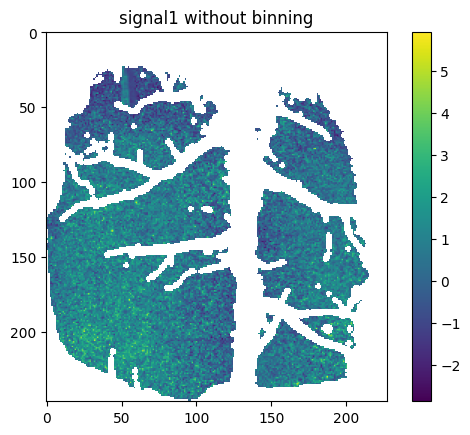

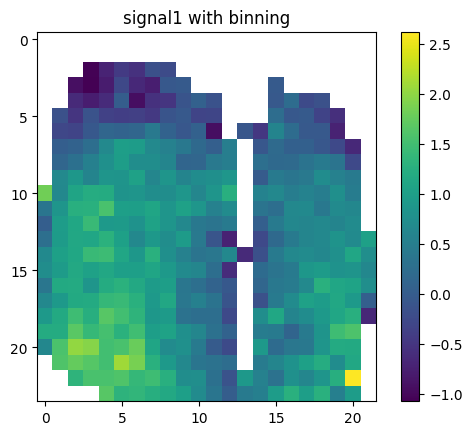

In [27]:
from utils.connectivity import bin_3d_matrix
from utils.other import plot_first_frame

signal1, attributes1 = get_data_from_dataset(signals_filename(mouse_num, filename_str), f"data/3d/{signal1_str}")
signal2, attributes2 = get_data_from_dataset(signals_filename(mouse_num, filename_str), f"data/3d/{signal2_str}")

# Note: I am certain that the bin_3d_matrix function could be greatly improved, for instance by using numba
binned_signal1 = bin_3d_matrix(signal1, bin_size)
binned_signal2 = bin_3d_matrix(signal2, bin_size)

plot_first_frame(signal1, title="signal1 without binning")
plot_first_frame(binned_signal1, title="signal1 with binning")

The execution of *bin_3d_matrix* can be rather long, so don't be surprised if it takes a few minutes with larger windows (another reason why pre-computing and saving the dFC frames is useful).

Of course, if you are working with small data, such as a small window or a small number of brain regions, it is possible that binning your data is unecessary. Simply try the next steps with your whole data to see what works.

### 3. Computing and saving dFC frames

Once your signal is binned appropriately, you can compute the dFC frames. By default the following functions compute the dFC frames in a flattened shape (so a $N\times M$ dFC matrix would instead be a $NM$ vector of dFC elements), but it is very simple to bring it back to a 2d matrix if needed.

In [28]:
from utils.ets import format_array
from numba import njit

@njit
def compute_dfc_flat(signals):
    T, N = signals.shape
    # print(f"{T}, {N}")
    triu_len = (N * (N + 1)) // 2  # Number of upper triangle elements (including diagonal)
    dFC_flat = np.zeros((T, triu_len))

    for t in range(T):
        idx = 0
        for i in range(N):
            for j in range(i, N):
                dFC_flat[t, idx] = signals[t, i] * signals[t, j]
                idx += 1

    return dFC_flat

log("Flattening signals.")
flattened_signal1, elements_mask = format_array(binned_signal1, return_mask=True)
flattened_signal2 = format_array(binned_signal2, return_mask=False)

log("Computing signal1 dfc")
dfc_signal1 = compute_dfc_flat(flattened_signal1)

log("Computing signal2 dfc")
dfc_signal2 = compute_dfc_flat(flattened_signal2)

log("Done!")

Elapsed time: 109.11 seconds.

Flattening signals.
Elapsed time: 0.02 seconds.

Computing signal1 dfc
Elapsed time: 0.48 seconds.

Computing signal2 dfc
Elapsed time: 2.15 seconds.

Done!


Notice the argument *return_mask* in *format_array*. What it does is, when flattening an array, return a 2D mask of where there are non-nan elements. When your data takes up the whole window (such as with *sample_data*) this makes no difference. However, when working with data that has nan values (such as with *sample_data_large*), knowing where those values are will be crucial if we wish to reconstruct the window later. 

The resulting data can be saved in the format of your choice, though I am partial to HDF5 files as usual. This is useful especially because you can store metadata along with the dFC frames, such as the spatial binning that was used, the elements mask and the window shape:

(The window shape and elements mask should be the same for both signals, so you can compute it only once)

In [ ]:
from utils.hdf5 import create_hdf5, save_dict_to_hdf5, add_attributes_to_dataset

dfc_arrays = [dfc_signal1, dfc_signal2]

for i, signal_str in enumerate([signal1_str, signal2_str]):

    filepath = f"sample_data/M{mouse_num}/M{mouse_num}_dfc_{filename_str}_{signal_str}.h5"

    create_hdf5(filepath=filepath, overwrite=True)

    data_to_save = {"dfc": dfc_arrays[i]}
    attributes_to_save = {"elements_mask": elements_mask, "window_shape": binned_signal1.shape, "binning_size": bin_size}

    save_dict_to_hdf5(filepath, data_to_save)
    add_attributes_to_dataset(filepath, "dfc", attributes_to_save)

HDF5 file 'sample_data/M396_dfc_sample_dataset_large_GCaMP.h5' created successfully.
Attributes added to dataset 'dfc': {'elements_mask': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True, False,
       False, False, F

Let us delete our variables and try to load the data to see what it looks like:

In [36]:
try:
    del signal1, signal2, binned_signal1, binned_signal2, flattened_signal1, flattened_signal2, dfc_signal1, dfc_signal2, elements_mask
except:
    pass

filepath = f"sample_data/M{mouse_num}/M{mouse_num}_dfc_{filename_str}_{signal1_str}.h5"
signal1_dfc, attributes1 = get_data_from_dataset(filepath, "dfc")

print(f"Shape of dfc array: {signal1_dfc.shape}")
print(f"Window shape attribute: {attributes1['window_shape']}")

Shape of dfc array: (1440, 81003)
Window shape attribute: [1440   24   22]


We obtain an array of shape $T\times (MN)^2$ (maximum, with the nan elements removed). The element mask is going to allow us to reconstitute the window shape if needed:

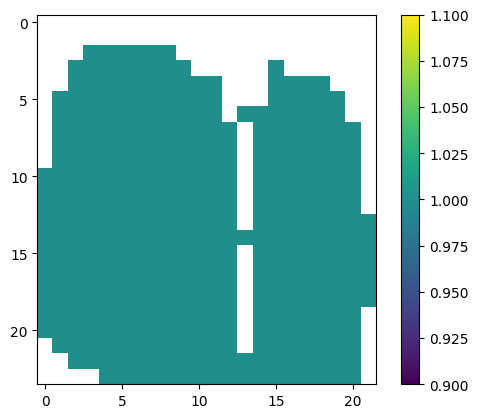

In [44]:
from utils.community_detection import communities_to_window

elements_mask = attributes1["elements_mask"]
window_shape = attributes1["window_shape"]
window = communities_to_window(elements_mask[elements_mask==True], elements_mask, window_shape)

plot_first_frame(window)

This going to be useful for things like community detection or labeling, loadings in the case of PCA or similar techniques, etc.

Now we have everything we need to actually compute the FC matrices. The FC across the whole signal will be computed simply as the average of the dFC frames across the whole array:

In [46]:
signal1_filepath = f"sample_data/M{mouse_num}/M{mouse_num}_dfc_{filename_str}_{signal1_str}.h5"
signal2_filepath = f"sample_data/M{mouse_num}/M{mouse_num}_dfc_{filename_str}_{signal2_str}.h5"

signal1_dfc, attributes1 = get_data_from_dataset(signal1_filepath, "dfc")
signal2_dfc, attributes2 = get_data_from_dataset(signal2_filepath, "dfc")

signal1_FC = np.mean(signal1_dfc, axis=0)
signal2_FC = np.mean(signal2_dfc, axis=0)

Notice that the function *compute_dfc_flat* only computes half of the full FC matrix. This is because the FC matrix is symmetrix by definition, so only one of the two triangles needs to be computed. It is easy to make it symmetric to display it however:

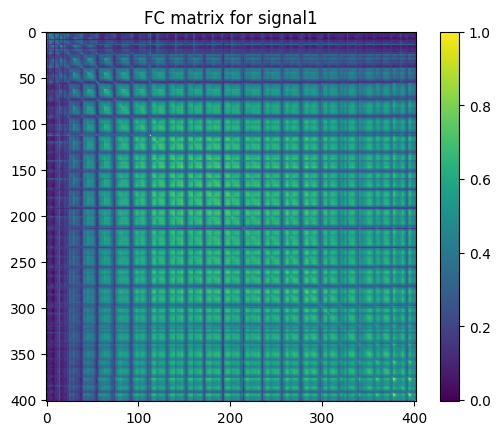

In [49]:
def flat_to_symmetric(flat, N):
    """Convert a flattened upper triangle vector to a full symmetric matrix."""
    mat = np.zeros((N, N))
    inds = np.triu_indices(N)
    mat[inds] = flat
    mat[(inds[1], inds[0])] = flat  # Reflect upper triangle to lower
    return mat

n_nodes = len(elements_mask[elements_mask==True])
whole_FC1 = flat_to_symmetric(signal1_FC, n_nodes)

plot_first_frame(whole_FC1, title="FC matrix for signal1")

Due to the geometric nature of the windows, you'll often see these striped patterns appear in the FC matrix. Community detection or clustering algorithms are useful to see if patterns emerge in those cases (I can suggest seaborn of sklearn for easy algorithms, or try those in *utils.community_detection*).

## Segmenting the data

In the examples above we have considered the whole time series when computing the neurovascular coupling or functional similarity. However, in some cases you may want to consider only part of it, for instance if you want to see what happens during a specific behavioral state, external stimuli, or other factor. If you know exactly the time steps or interval you want to consider, this is as easy as slicing your data before making the computations so as to keep only the specific period of interest.

In some cases though, you don't know the specific indices beforehand. This is often the case when working with tertiary signals: for example, if you want to compute the neurovascular coupling and functional similarity between signal1 and signal2 *only* during periods where signal3 is very high (signal3 could be, for instance pupil diameter, face motion, GRAB-NE signal, optogenetics signal, etc.).

When that is the case, there are also specific functions that can allow you to split the signal based on segments. Let us make an easy example here. We have a 1d sinusoidal signal, and we want to split it into three segments: one with high amplitude, one with low amplitude, and one with medium amplitude.

In [65]:
sine_signal = np.sin(np.arange(0, 15, 0.1))

mats, indices = split_into_bins(sine_signal, 3)

Here the *indices* variable gives you the indices where the condition is met, and *mats* gives you the elements associated with those indices. For example *indices[0]* would give you the indices associated with the timesteps where the sinus function is at its highest third, and *indices[2]* would give you the indices of the timesteps where it is at its lowest third. *mats[0]* would give you the amplitude values associated with the timesteps if *indices[0]*, and so on.

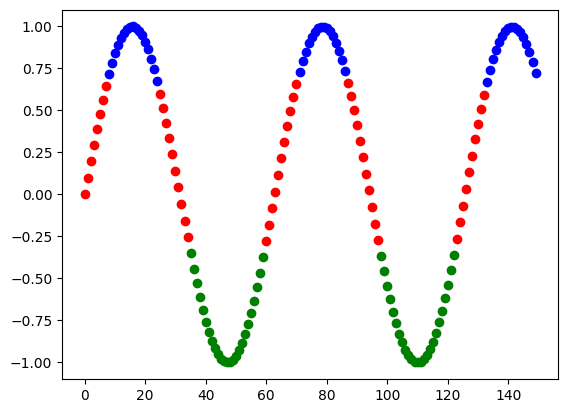

In [70]:
plt.scatter(indices[0], mats[0], color="blue")
plt.scatter(indices[1], mats[1], color="red")
plt.scatter(indices[2], mats[2], color="green")
plt.show()

Notice that the amplitude span of each segment is not necessarily equivalent, but that they will always contain an equal number of time steps.

On its own this function is not particularly noteworthy, but it is useful when coupled with the computations detailed above when using a third signal. For instance, if I wanted to compute the FC for each individual segment instead of computing it for the whole timeseries, I would do something like:

```signal1_FC_segments = [np.mean(signal1_dfc[idx,:], axis=0) for idx in indices]```

Which would split up my FC matrix in however many segments in chose based on an external criteria.